# **EXPLORATORY DATA ANALYSIS FOR HOUSE PRICES**

## **INITIALIZATION**

In [37]:
# load required packages
import os

import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('bmh')
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew

In [38]:
# ignore warnings from sklearn and seaborn
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

# pandas output format
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

In [39]:
# check files available
from subprocess import check_output
print(check_output(['ls', os.getcwd()]).decode('utf8'))

gender_submission.csv
model.R
outcomes.csv
submission_SVC_1.csv
submission_SVC_2.csv
submission_SVC_3.csv
submission_SVC_4.csv
SVC-titanic.ipynb
test.csv
test_engineered.csv
train.csv
train_engineered.csv
XGB-titanic.ipynb
yhat.csv



## **EXPLORATION**

In [40]:
# load train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.shape, test.shape)

# drop identifier column
train_id = train['PassengerId']
test_id = test['PassengerId']
del train['PassengerId']
del test['PassengerId']
train.info()

(891, 12) (418, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


Text(0.5, 1.0, 'Male')

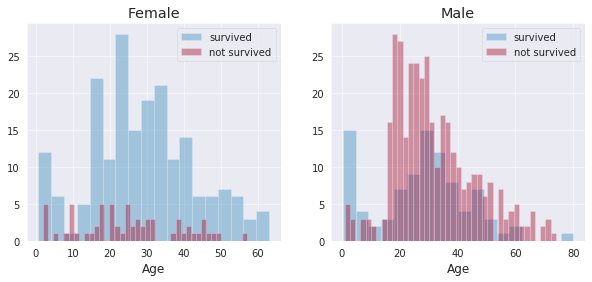

In [41]:
# distribution plot of outcomes by sex and age
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
women = train[train['Sex'] == 'female']
men = train[train['Sex'] == 'male']

ax = sns.distplot(women[women['Survived'] == 1].Age.dropna(), bins=18, label = 'survived',\
                 ax = axes[0], kde=False)
ax = sns.distplot(women[women['Survived'] == 0].Age.dropna(), bins=40, label = 'not survived',\
                 ax = axes[0], kde=False)
ax.legend()
ax.set_title('Female')

ax = sns.distplot(men[men['Survived'] == 1].Age.dropna(), bins=18, label = 'survived',\
                 ax = axes[1], kde=False)
ax = sns.distplot(men[men['Survived'] == 0].Age.dropna(), bins=40, label = 'not survived',\
                 ax = axes[1], kde=False)
ax.legend()
ax.set_title('Male')

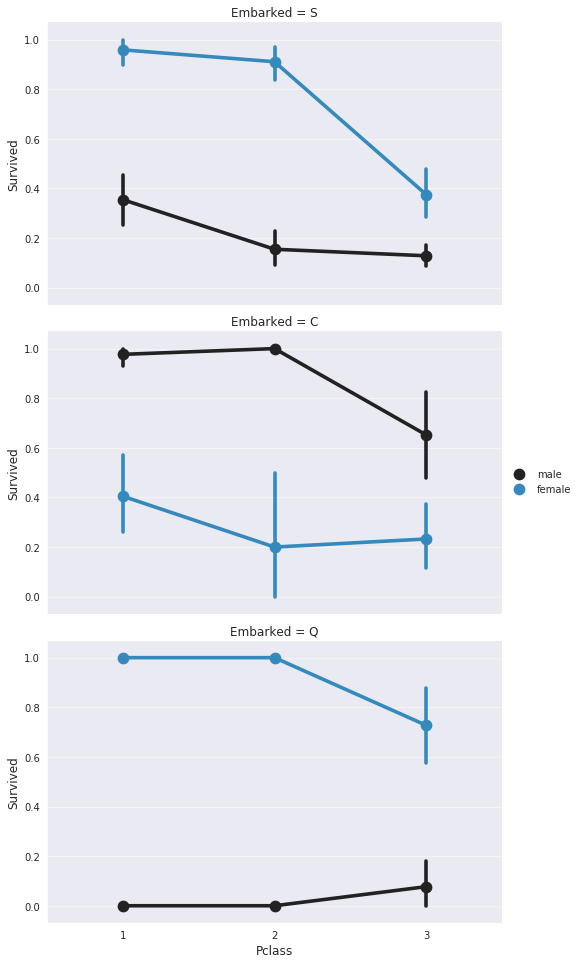

In [42]:
# outcomes by embarked, pclass and sex
FacetGrid = sns.FacetGrid(train, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', 
              palette=None, order=None, hue_order=None)
FacetGrid.add_legend()

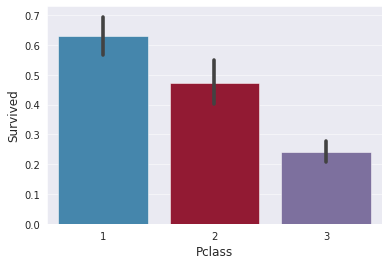

In [43]:
# outcome by pclass
sns.barplot(x='Pclass', y='Survived', data = train)

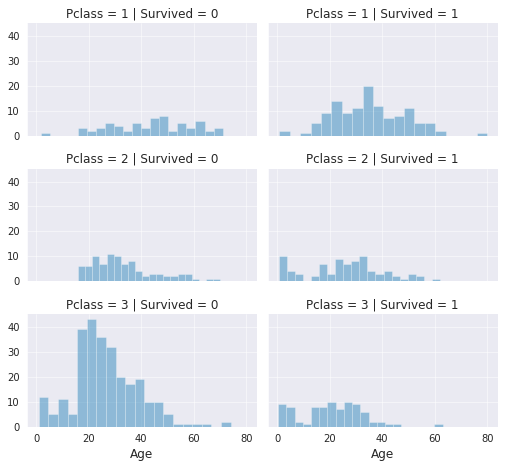

In [44]:
#outcome by class and age
grid = sns.FacetGrid(train, col = 'Survived', row = 'Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=0.5, bins=20)
grid.add_legend();

## **FEATURE ENGINEERING**

In [45]:
# data manipulation
n_train = train.shape[0]
n_test = test.shape[0]
y = train['Survived'].values
df = pd.concat((train, test)).reset_index(drop=True)
del df['Survived']
print(n_train)

891


In [46]:
# deal with missing data
df_nan = df.isnull().sum() / len(df) * 100
df_nan = df_nan.drop(df_nan[df_nan == 0].index).sort_values(ascending=False)
print(df_nan[:10])

# f, ax = plt.subplots(figsize=(10,10))
# plt.xticks(rotation='90')
# sns.barplot(x=df_nan.index[:10], y=df_nan[:10])
# plt.xlabel('Features', fontsize=12)
# plt.ylabel('% missing', fontsize=12)
# plt.title('% missing by feature', fontsize=12)

Cabin      77.464
Age        20.092
Embarked    0.153
Fare        0.076
dtype: float64


In [47]:
from itertools import groupby

def split_text(s):
        for k, g in groupby(s, str.isalpha):
            yield ''.join(g)

In [48]:
# helper functions I
# add 'deck' and 'room' based on the cabin number provided

#deck =['Boat', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'Orlop', 'Tank Top'] # 10 decks
cabin = df['Cabin'].tolist()
d = {i:list(split_text(str(e))) for i, e in enumerate (cabin)}

deck = []
room = []
for i, (k,v) in enumerate (d.items()):
    if v[0] != 'nan':
        deck.append(v[0])
        if len(v) > 1:
            if v[1].isnumeric():
                room.append(int(v[1]))
            else:
                room.append(np.nan)
        else: 
            room.append(np.nan)
    else: 
        deck.append(None)
        room.append(np.nan)

#print(deck)
#print(room)

In [49]:
# some tickets have prefixes, not sure about meaning
ticketvar=[]
for i in df['Ticket']:
    tmp = i.split(' ')
    if len(set(tmp)) == 2:
        ticketvar.append(tmp[0].split('/')[0].replace('.',''))
    else:
        ticketvar.append('None')

In [50]:
# adding features
df2 = df.copy()
df2['FamilySize'] = df2['SibSp'] + df2['Parch'] + 1
df2['Deck'] = pd.Series(deck)
df2['Room'] = pd.Series(room)
df2['TicketVar'] = pd.Series(ticketvar)
df2['FamilyName'] = [i.split(',')[0] for i in df2['Name']]
#print(df2.head())

In [51]:
# replace missing values for deck
mask = df2['Pclass'] == 3
df2.loc[mask, 'Deck'] = df2.loc[mask, 'Deck'].fillna('F') # most F, a few on G deck
mask = df2['Pclass'] == 2
df2.loc[mask, 'Deck'] = df2.loc[mask, 'Deck'].fillna(df2.loc[mask, 'Deck'].mode()[0]) # most D to F deck
mask = df2['Pclass'] == 1
df2.loc[mask, 'Deck'] = df2.loc[mask, 'Deck'].fillna(df2.loc[mask, 'Deck'].mode()[0]) # most D to F deck

In [52]:
# replace missing values for age
mask = ((df2['FamilySize'] == 1) | (df2['Parch'] == 0)) # most likely adults
df2.loc[mask, 'Age'] = df2.loc[mask, 'Age'].fillna(df2.loc[mask, 'Age'].mean())
df2.loc[~mask, 'Age'] = df2.loc[~mask, 'Age'].fillna(df2.loc[~mask, 'Age'].median())

In [53]:
# bin age feature
bins = [0, 2, 5, 10, 18, 35, 65, np.inf]
names = ['<2', '2-5', '5-10', '10-18', '18-35', '35-65', '65+']
df2['AgeRange'] = pd.cut(df2['Age'], bins, labels=names)

In [54]:
df2['Fare'].describe()

count   1308.000
mean      33.295
std       51.759
min        0.000
25%        7.896
50%       14.454
75%       31.275
max      512.329
Name: Fare, dtype: float64

In [55]:
# clean up fare feature
#df2['Fare'].describe()
df2['Fare'].fillna(df2['Fare'].median(), inplace=True)
df2['Fare'] = df2['Fare'].astype(int)

bins = [0, 5, 10, 15, 30, 50, np.inf]
names = ['<5', '5-10', '10-15', '15-30', '30-50', '50+']
df2['FareRange'] = pd.cut(df2['Fare'], bins, labels=names)

In [56]:
# clean up familyname feature
df2['FamilyName'] = df2['FamilyName'] + '_' + df2['FamilySize'].astype(str)

In [57]:
# drop 'cabin' and replace remaining missing values
df2.drop(['Cabin', 'Name', 'Ticket'], axis=1, inplace=True)

df2['Embarked'].fillna(df2['Embarked'].mode()[0], inplace=True)
df2['Deck'].fillna('None', inplace=True)
df2['Room'].fillna(0, inplace=True)

#print(df2[df2['Age'].isnull()])

In [58]:
# check if remaining missing values
df2_nan = df2.isnull().sum() / len(df2) * 100
#print(df2_nan)

In [59]:
# transform some numerical variables to categorical
ls =['Sex', 'Embarked', 'Deck', 'AgeRange', 'FareRange', 'TicketVar', 'FamilyName']
    
# label encoding for categorical variables
from sklearn.preprocessing import LabelEncoder
for f in ls:
    print(f)
    lbl = LabelEncoder()
    lbl.fit(list(df2[f].values))
    df2[f] = lbl.transform(list(df2[f].values))
print(df2.shape)

Sex
Embarked
Deck
AgeRange
FareRange
TicketVar
FamilyName
(1309, 14)


In [60]:
# split between numerical and categorical features
#df_num = df2.select_dtypes(include = ['float64', 'int64']) # 109 features + SalePrice
#num_skewed = df_num.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
#skewness = pd.DataFrame({'Skew': num_skewed})
#print(skewness.head(5))

In [61]:
# box-cox transformation of highly skewed features
#skewness = skewness[abs(skewness) > 0.75]
#skewness.drop('lat', inplace=True)
#skewness.drop('lon', inplace=True)
#print(skewness.shape[0])
#lam=0.15
#from scipy.special import boxcox1p
#for f in skewness.index:
#    if (f != 'lon') | (str(f)!= 'lat'):
#            print(f)
#            df2[f] = boxcox1p(df2[f], lam)

In [62]:
# create dummies for categorical variables
df3 = df2.copy() #keep original df
df3 = pd.get_dummies(df3)
print(df3.shape)

(1309, 14)


In [63]:
# split between train and test after feature engineering
train = df3[:n_train]; train['PassengerId'] = train_id.values; train.set_index('PassengerId')
test = df3[n_train:]; test['PassengerId'] = test_id.values; test.set_index('PassengerId')
outcomes = pd.DataFrame({'Survived': y})
outcomes['PassengerId'] = train_id.values; outcomes.set_index('PassengerId')

train.to_csv('train_engineered.csv')
test.to_csv('test_engineered.csv')
outcomes.to_csv('outcomes.csv')

## **MODEL**

In [64]:
train = pd.read_csv('train_engineered.csv')
test = pd.read_csv('test_engineered.csv')
outcomes = pd.read_csv('outcomes.csv')
y = np.asarray(outcomes['Survived'].values)
train_id = train['PassengerId']; test_id = test['PassengerId']
del train['PassengerId']
del test['PassengerId']

X = np.asarray(train)
X_forecast = np.asarray(test)
print(X.shape, y.shape, X_forecast.shape)

(891, 15) (891,) (418, 15)


In [65]:
# split the dataset in train and validation sets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)
# print ('Train set:', X_train.shape,  y_train.shape)
# print ('Test set:', X_test.shape,  y_test.shape)

In [66]:
# skip validation set
X_train = X
y_train = y

In [67]:
# set the parameters by cross-validation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

#y_scaler = StandardScaler()
#y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))

pipe = Pipeline(steps=[('scaler', StandardScaler()), ('estimator', SVC())])
param_grid=dict(estimator__kernel = ['rbf', 'linear'],
                estimator__C = [0.1, 0.25, 0.5, 0.75, 1, 1.5, 1.75, 2, 2.25, 2.5, 3, 3.5, 4],
                estimator__gamma = [0.01, 0.015, 0.02, 0.025, 0.05, 0.075, 0.1, 0.125, 0.2])

search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_train, y_train)
print(search.best_params_)
# {'estimator__C': 1.5, 'estimator__gamma': 0.025, 'estimator__kernel': 'rbf'}

{'estimator__C': 3, 'estimator__gamma': 0.015, 'estimator__kernel': 'rbf'}


In [68]:
# yhat = search.predict(X_test)
# print(sum(yhat == y_test) / len(yhat) * 100)

In [69]:
prediction = search.predict(X_forecast)
pd.DataFrame(prediction).to_csv('yhat.csv')

In [70]:
# performance evaluation

def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))
    
    # show features
    if top == -1:
        top = len(names)
    
    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()
    
labels = train.columns.tolist()
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

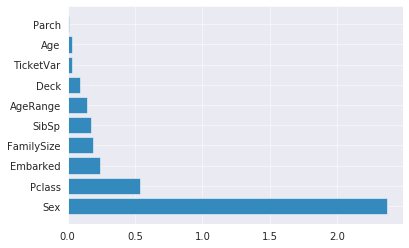

In [71]:
f_importances(abs(svm.coef_[0]), labels, top=10)